# Make some paper figs

In [28]:
import numpy as np
from pathlib import Path
import os
import re
import h5py
import pandas as pd
import logging
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

from graspy.plot import pairplot, heatmap
from lol import LOL
from hyppo.independence import Dcorr
from scipy.stats import multiscale_graphcorr, ttest_rel, ttest_ind
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances

from nilearn import datasets, plotting
import nibabel as nib
import matplotlib as mpl

import sys; sys.path.append('../')
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
datadir = Path('/mnt/ssd3/ronan/data')
tag = '_min_rank-ZG3'#'_max_rank-ZG2' 
gccadir = datadir / f'gcca_05-26-10:39{tag}'#f'gcca_05-17-18:27{tag}' # 
external_dir = Path('../data/external')

save_dir = Path('../reports/pairwise_differences_8-14/')

In [77]:
## Gradients
gradients = [
    (0), (1), (2),
    #(0,1), (1,2), (2,0),
    #(0,1,2)
]

lookup = {'Experts All':[0,1,2],
          'Novices All':[3,4,5],
          'Experts Resting':[0],
          'Experts Open Monitoring':[1],
          'Experts Compassion':[2],
          'Novices Resting':[3],
          'Novices Open Monitoring':[4],
          'Novices Compassion':[5],
          'Experts Meditating':[1,2],
          'Novices Meditating':[4,5],
          'Resting':[0,3],
          'Compassion':[2,5],
          'Open Monitoring':[1,4],
          'Meditating':[1,2,4,5]
}
test_list = []
# ## Intra (within) Trait, Inter (between) State
test_list += [
    # Permutation: restricted, within subject
    ('Experts Resting', 'Experts Compassion', 'within'),
    ('Experts Resting', 'Experts Open Monitoring', 'within'),
    ('Experts Open Monitoring', 'Experts Compassion', 'within'),
    # ('Experts Resting', 'Experts Meditating', 'within'),
    ('Novices Resting', 'Novices Compassion', 'within'),
    ('Novices Resting', 'Novices Open Monitoring', 'within'),
    ('Novices Open Monitoring', 'Novices Compassion', 'within'),
    # ('Novices Resting', 'Novices Meditating', 'within')
]
# ## Inter (between) Trait, Intra (within) State
test_list += [
    # Permutation: full
    ('Experts Resting', 'Novices Resting', 'full'),
    ('Experts Compassion', 'Novices Compassion', 'full'),
    ('Experts Open Monitoring', 'Novices Open Monitoring', 'full'),
]
# Permutation: restricted, across subject
test_list += [
    ('Experts Meditating', 'Novices Meditating', 'across'),
    ('Experts All', 'Novices All', 'across'),
]
## Inter (between) Trait, Inter (between) State
test_list += [
    # Permutation: free
    ('Experts Resting', 'Novices Compassion', 'full'),
    ('Experts Resting', 'Novices Open Monitoring', 'full'),
    ('Experts Compassion', 'Novices Resting', 'full'),
    ('Experts Compassion', 'Novices Open Monitoring', 'full'),
    ('Experts Open Monitoring', 'Novices Resting', 'full'),
    ('Experts Open Monitoring', 'Novices Compassion', 'full'),
    # Permutation: restricted, permute state (preserve # labels)
    # # ('Experts Resting', 'Novices Meditating', 'across'),
    # # ('Experts Meditating', 'Novices Resting', 'across'),
]
# # Intra State (need to figure out these permutations)
test_list += [
    # Permutation: restricted, permute state
    ('Resting', 'Compassion', 'within'),
    ('Resting', 'Open Monitoring', 'within'),
    ('Compassion', 'Open Monitoring', 'within'),
    # Permutation: restricted, permute state (preserve # labels)
    # ('Resting', 'Meditating', 'within')
]

SIGNIFICANT_TESTS = [3,5,17,19]

In [4]:
# plot on fsa5 surface:
fsa5 = datasets.fetch_surf_fsaverage()

In [5]:
def visualize_embeddings(
    embeddings,
    save_path=False,
    vmax=None,
    symmetric_cbar=True,
    colorbar=False,
    n_embed = 1,
    title = None,
):
    plt.clf()
    res_scale = 2
    fig, axes = plt.subplots(n_embed, 4, subplot_kw={'projection': '3d'}, figsize=(res_scale*5, res_scale*n_embed))
    if n_embed==1:
        axes = [axes]
    
    plt.subplots_adjust(wspace=0, hspace=0)        

    for i,ax in enumerate(axes):
        X = embeddings[:, i]

        cortex_left = nib.freesurfer.read_label(external_dir / 'lh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_left] = X[:len(cortex_left)]

        plotting.plot_surf_stat_map(fsa5.infl_left, 
          conn_map, hemi='left', colorbar=False, cmap='RdBu', axes = ax[0],
          vmax=vmax, symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_left,
          conn_map, hemi='left', colorbar=False, cmap='RdBu', view='medial', axes=ax[1], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

        cortex_right = nib.freesurfer.read_label(external_dir / 'rh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_right] = X[len(cortex_left):]

        plotting.plot_surf_stat_map(fsa5.infl_right, 
          conn_map, hemi='right', colorbar=False, cmap='RdBu', axes = ax[2], 
           vmax=vmax,symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_right,
          conn_map, hemi='right', colorbar=colorbar, cmap='RdBu', view='medial', axes=ax[3], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

    if title:
        fig.suptitle(title, fontsize=20, y=0.92)
    if save_path:
        plt.savefig(f'{str(save_path)}.png', format='png', bbox_inches='tight')
    else:
        return fig
#         plt.show()
#         plt.close(fig)
    
def make_cbar(vmax, save_path = None, vmin=None):
    if vmin is None:
        vmin = -vmax
        cmap = mpl.cm.RdBu
    else:
        cmap = mpl.cm.Blues
    fig, ax = plt.subplots(figsize=(1, 15))
    fig.subplots_adjust(bottom=0.5)

    #cmap = mpl.cm.RdBu
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    
    #cb1.set_clim(vmin, vmax)
    #cb1.set_label('Some Units')
    if save_path:
        plt.savefig(f'{str(save_path)}.pdf', bbox_inches='tight')
    plt.close(fig)

### Pairwise diff figures (welch t-stats) for all gradients

In [8]:
groups, labels, subjs = get_latents(gccadir, flag="_gcca", ids=True)

In [9]:
SAVE = True
COLORBAR = False

Experts Resting vs. Experts Compassion: Gradient 1


<Figure size 432x288 with 0 Axes>

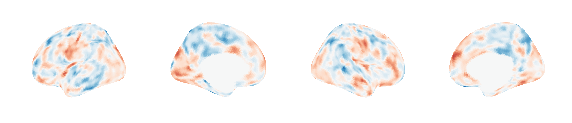

Experts Resting vs. Experts Compassion: Gradient 2


<Figure size 432x288 with 0 Axes>

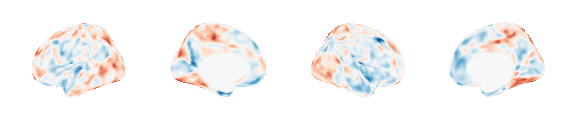

Experts Resting vs. Experts Compassion: Gradient 3


<Figure size 432x288 with 0 Axes>

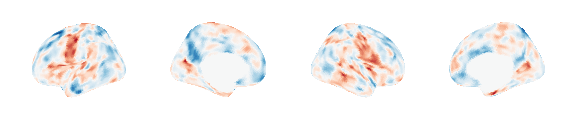

Experts Resting vs. Experts Open Monitoring: Gradient 1


<Figure size 432x288 with 0 Axes>

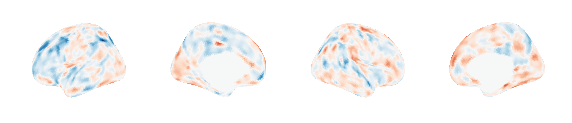

Experts Resting vs. Experts Open Monitoring: Gradient 2


<Figure size 432x288 with 0 Axes>

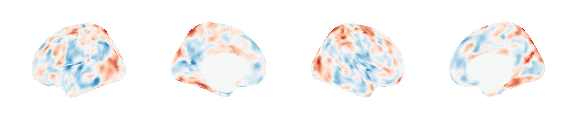

Experts Resting vs. Experts Open Monitoring: Gradient 3


<Figure size 432x288 with 0 Axes>

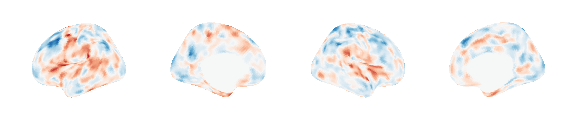

Experts Open Monitoring vs. Experts Compassion: Gradient 1


<Figure size 432x288 with 0 Axes>

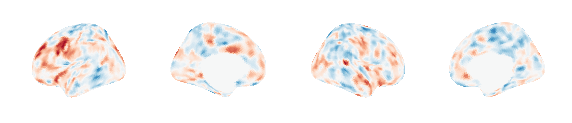

Experts Open Monitoring vs. Experts Compassion: Gradient 2


<Figure size 432x288 with 0 Axes>

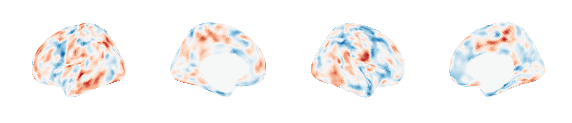

Experts Open Monitoring vs. Experts Compassion: Gradient 3


<Figure size 432x288 with 0 Axes>

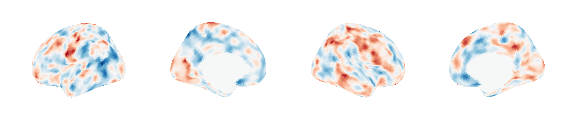

Novices Resting vs. Novices Compassion: Gradient 1


<Figure size 432x288 with 0 Axes>

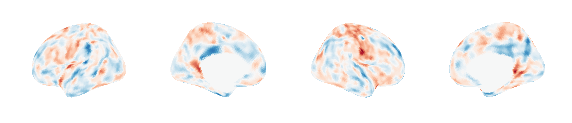

Novices Resting vs. Novices Compassion: Gradient 2


<Figure size 432x288 with 0 Axes>

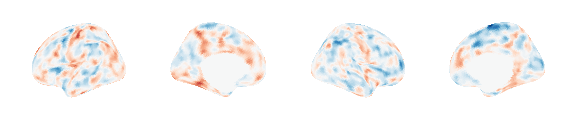

Novices Resting vs. Novices Compassion: Gradient 3


<Figure size 432x288 with 0 Axes>

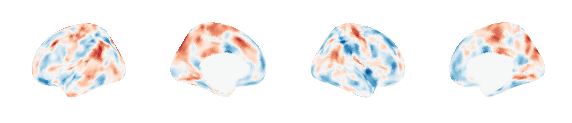

Novices Resting vs. Novices Open Monitoring: Gradient 1


<Figure size 432x288 with 0 Axes>

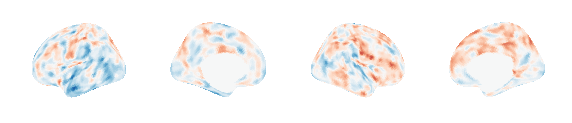

Novices Resting vs. Novices Open Monitoring: Gradient 2


<Figure size 432x288 with 0 Axes>

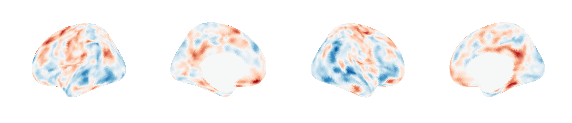

Novices Resting vs. Novices Open Monitoring: Gradient 3


<Figure size 432x288 with 0 Axes>

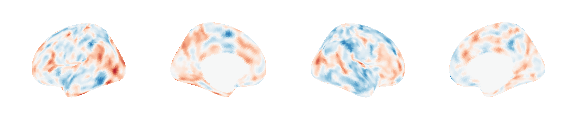

Novices Open Monitoring vs. Novices Compassion: Gradient 1


<Figure size 432x288 with 0 Axes>

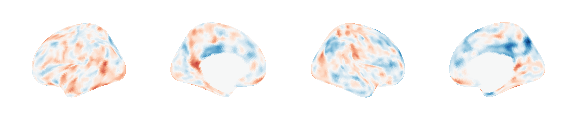

Novices Open Monitoring vs. Novices Compassion: Gradient 2


<Figure size 432x288 with 0 Axes>

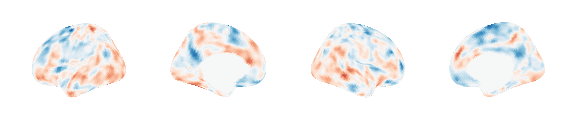

Novices Open Monitoring vs. Novices Compassion: Gradient 3


<Figure size 432x288 with 0 Axes>

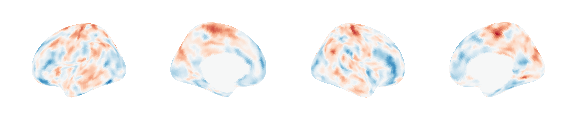

Experts Resting vs. Novices Resting: Gradient 1


<Figure size 432x288 with 0 Axes>

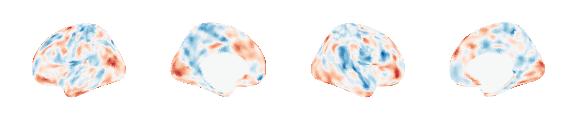

Experts Resting vs. Novices Resting: Gradient 2


<Figure size 432x288 with 0 Axes>

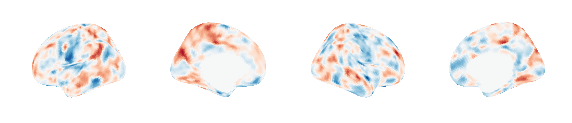

Experts Resting vs. Novices Resting: Gradient 3


<Figure size 432x288 with 0 Axes>

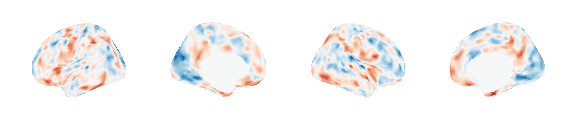

Experts Compassion vs. Novices Compassion: Gradient 1


<Figure size 432x288 with 0 Axes>

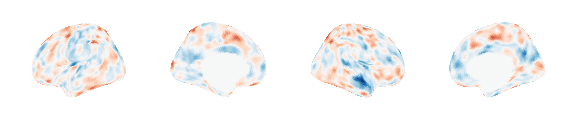

Experts Compassion vs. Novices Compassion: Gradient 2


<Figure size 432x288 with 0 Axes>

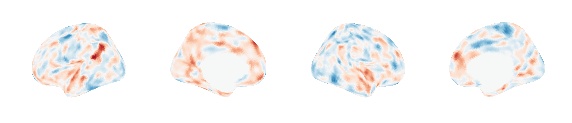

Experts Compassion vs. Novices Compassion: Gradient 3


<Figure size 432x288 with 0 Axes>

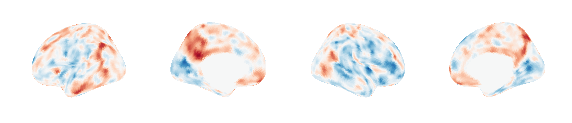

Experts Open Monitoring vs. Novices Open Monitoring: Gradient 1


<Figure size 432x288 with 0 Axes>

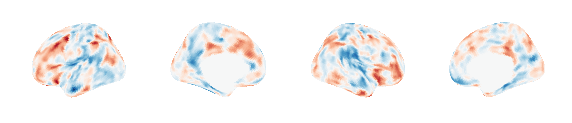

Experts Open Monitoring vs. Novices Open Monitoring: Gradient 2


<Figure size 432x288 with 0 Axes>

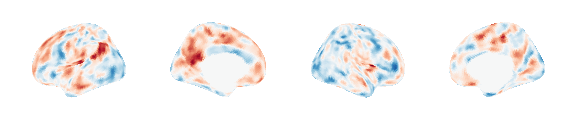

Experts Open Monitoring vs. Novices Open Monitoring: Gradient 3


<Figure size 432x288 with 0 Axes>

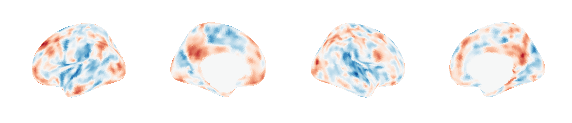

Experts Meditating vs. Novices Meditating: Gradient 1


<Figure size 432x288 with 0 Axes>

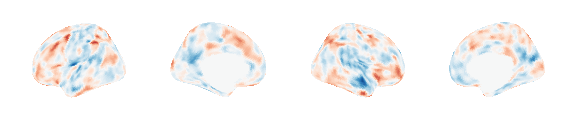

Experts Meditating vs. Novices Meditating: Gradient 2


<Figure size 432x288 with 0 Axes>

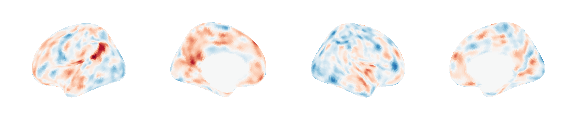

Experts Meditating vs. Novices Meditating: Gradient 3


<Figure size 432x288 with 0 Axes>

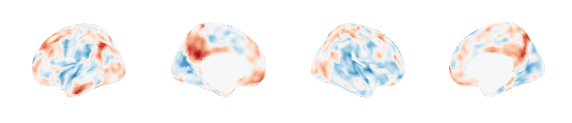

Experts All vs. Novices All: Gradient 1


<Figure size 432x288 with 0 Axes>

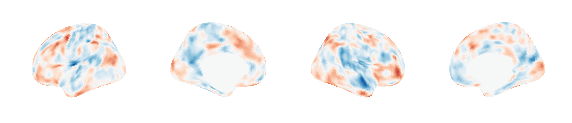

Experts All vs. Novices All: Gradient 2


<Figure size 432x288 with 0 Axes>

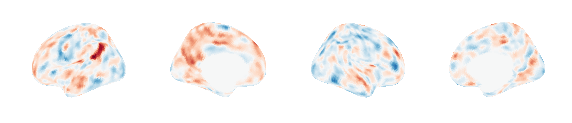

Experts All vs. Novices All: Gradient 3


<Figure size 432x288 with 0 Axes>

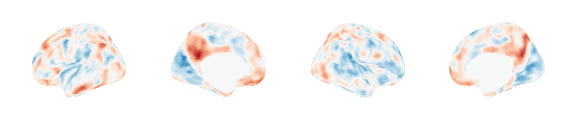

Experts Resting vs. Novices Compassion: Gradient 1


<Figure size 432x288 with 0 Axes>

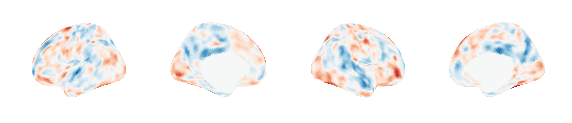

Experts Resting vs. Novices Compassion: Gradient 2


<Figure size 432x288 with 0 Axes>

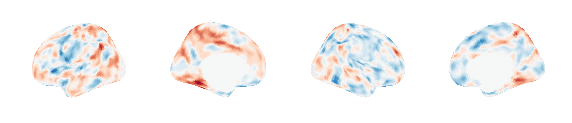

Experts Resting vs. Novices Compassion: Gradient 3


<Figure size 432x288 with 0 Axes>

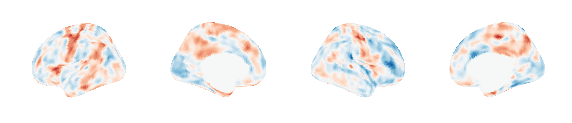

Experts Resting vs. Novices Open Monitoring: Gradient 1


<Figure size 432x288 with 0 Axes>

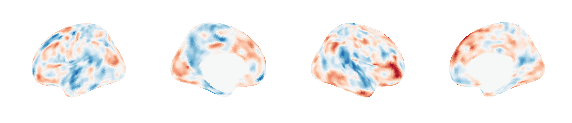

Experts Resting vs. Novices Open Monitoring: Gradient 2


<Figure size 432x288 with 0 Axes>

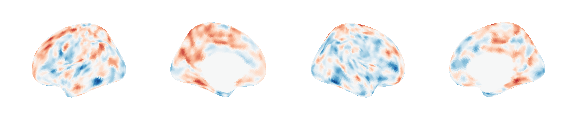

Experts Resting vs. Novices Open Monitoring: Gradient 3


<Figure size 432x288 with 0 Axes>

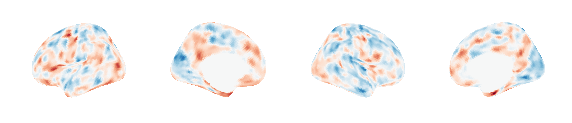

Experts Compassion vs. Novices Resting: Gradient 1


<Figure size 432x288 with 0 Axes>

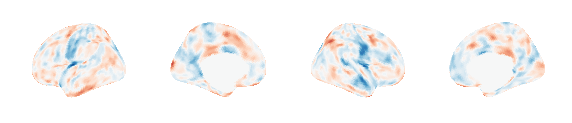

Experts Compassion vs. Novices Resting: Gradient 2


<Figure size 432x288 with 0 Axes>

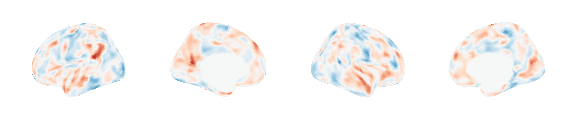

Experts Compassion vs. Novices Resting: Gradient 3


<Figure size 432x288 with 0 Axes>

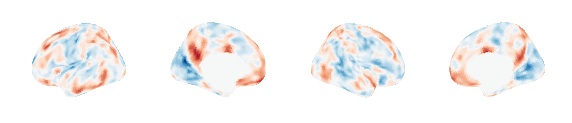

Experts Compassion vs. Novices Open Monitoring: Gradient 1


<Figure size 432x288 with 0 Axes>

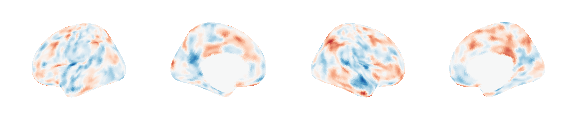

Experts Compassion vs. Novices Open Monitoring: Gradient 2


<Figure size 432x288 with 0 Axes>

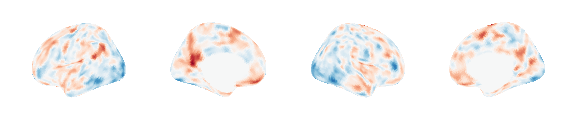

Experts Compassion vs. Novices Open Monitoring: Gradient 3


<Figure size 432x288 with 0 Axes>

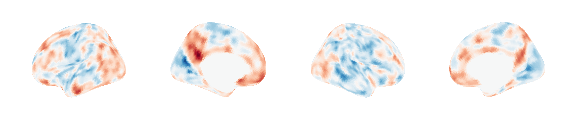

Experts Open Monitoring vs. Novices Resting: Gradient 1


<Figure size 432x288 with 0 Axes>

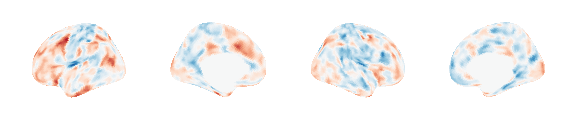

Experts Open Monitoring vs. Novices Resting: Gradient 2


<Figure size 432x288 with 0 Axes>

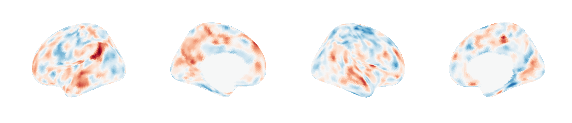

Experts Open Monitoring vs. Novices Resting: Gradient 3


<Figure size 432x288 with 0 Axes>

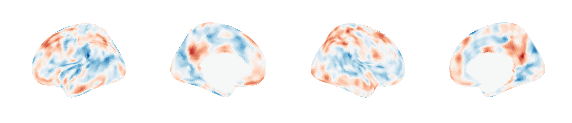

Experts Open Monitoring vs. Novices Compassion: Gradient 1


<Figure size 432x288 with 0 Axes>

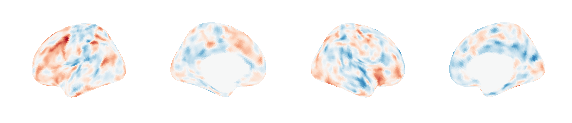

Experts Open Monitoring vs. Novices Compassion: Gradient 2


<Figure size 432x288 with 0 Axes>

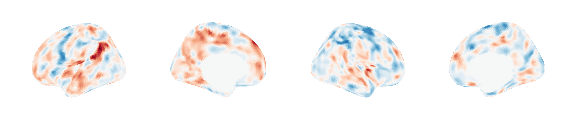

Experts Open Monitoring vs. Novices Compassion: Gradient 3


<Figure size 432x288 with 0 Axes>

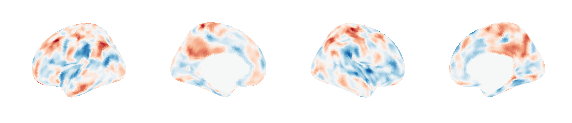

Resting vs. Compassion: Gradient 1


<Figure size 432x288 with 0 Axes>

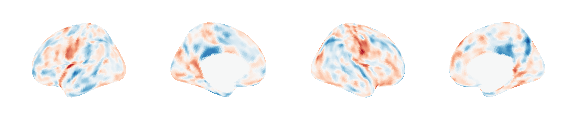

Resting vs. Compassion: Gradient 2


<Figure size 432x288 with 0 Axes>

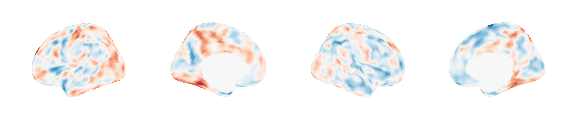

Resting vs. Compassion: Gradient 3


<Figure size 432x288 with 0 Axes>

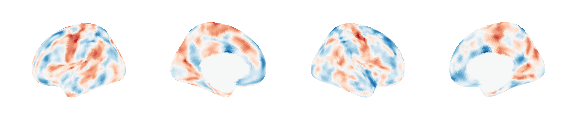

Resting vs. Open Monitoring: Gradient 1


<Figure size 432x288 with 0 Axes>

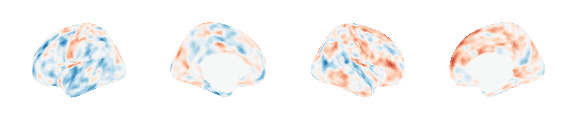

Resting vs. Open Monitoring: Gradient 2


<Figure size 432x288 with 0 Axes>

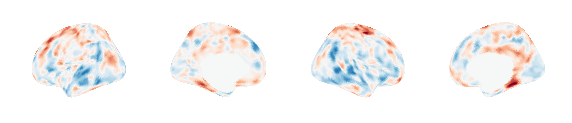

Resting vs. Open Monitoring: Gradient 3


<Figure size 432x288 with 0 Axes>

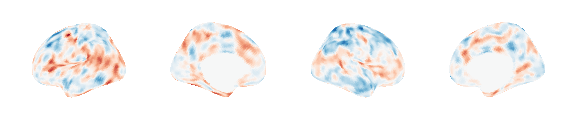

Compassion vs. Open Monitoring: Gradient 1


<Figure size 432x288 with 0 Axes>

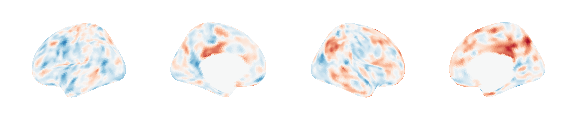

Compassion vs. Open Monitoring: Gradient 2


<Figure size 432x288 with 0 Axes>

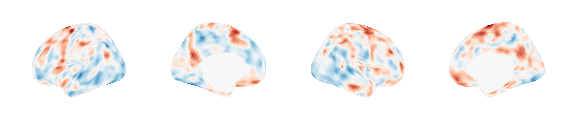

Compassion vs. Open Monitoring: Gradient 3


<Figure size 432x288 with 0 Axes>

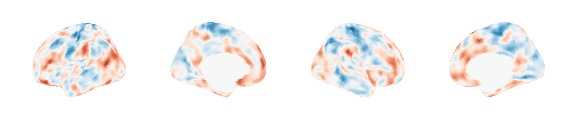

In [18]:
for (g1,g2,permute_structure) in test_list:
    name = f'{g1} vs. {g2}'
    results_dict = {}
    
    g1_labels = lookup[g1]
    g2_labels = lookup[g2]

    X1 = np.vstack([np.asarray(groups[i]) for i in g1_labels])
    X2 = np.vstack([np.asarray(groups[i]) for i in g2_labels])
    
    subjs1 = np.concatenate([np.asarray(subjs[i]) for i in g1_labels])
    subjs2 = np.concatenate([np.asarray(subjs[i]) for i in g2_labels])
    if permute_structure == 'within':
        X1 = X1[np.argsort(subjs1)]
        X2 = X2[np.argsort(subjs2)]
    
    tstats = []
    for grads in gradients:
        X1g = X1[:, :, grads].reshape(X1.shape[0], -1)
        X2g = X2[:, :, grads].reshape(X2.shape[0], -1)
        
        #tstats_mu = X1g.mean(axis=0) - X2g.mean(axis=0)
        #tstats_var = X1g.var(axis=0, ddof=1) / X1g.shape[0] + X2g.var(axis=0, ddof=1) / X2g.shape[0]
        #tstats.append(tstats_mu / np.sqrt(tstats_var))
        if permute_structure == 'within':
            tstats.append(ttest_rel(X1g, X2g, axis=0)[0])
        else:
            tstats.append(ttest_ind(X1g, X2g, axis=0, equal_var=False)[0])
        
    vmax = np.max(np.abs(np.concatenate(tstats)))
    for tstat, grads in zip(tstats, gradients):
        print(f'{name}: Gradient {grads+1}')
        if COLORBAR:
            vmax = np.max(np.abs(tstat))
        if SAVE:
            title = False
        else:
            title = name
        visualize_embeddings(
            tstat[:,None],
            save_path=False,
            colorbar=COLORBAR,
            n_embed=1,
            vmax=vmax,
            title=title,
        )

        if SAVE:
            plt.savefig(save_dir / f'{name}_{grads}_tstats.pdf', bbox_inches='tight', pad_inches = 0)
            plt.show()
        else:
            plt.show()
    
    if SAVE and not COLORBAR:
        make_cbar(vmax, save_dir / f'{name}_colorbar')

### Heatmaps

In [69]:
heatmap_dir = Path('../reports/heatmaps_8-14/')

In [26]:
X = np.vstack(groups)
X = X.reshape(X.shape[0], -1)
X = X[np.argsort(np.concatenate(subjs)),:]
X_dists = pairwise_distances(X, metric="euclidean")

In [33]:
def center_distmat(distx):  # pragma: no cover
    """Centers the distance matrices"""
    n = distx.shape[0]
    exp_distx = (
        np.repeat((distx.sum(axis=0) / (n - 2)), n).reshape(-1, n).T
        + np.repeat((distx.sum(axis=1) / (n - 2)), n).reshape(-1, n)
        - distx.sum() / ((n - 1) * (n - 2))
    )
    cent_distx = distx - exp_distx
    np.fill_diagonal(cent_distx, 0)
    return cent_distx

In [101]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def _unique_like(vals):
    # gives output like
    uniques, inds, counts = np.unique(vals, return_index=True, return_counts=True)
    inds_sort = np.argsort(inds)
    uniques = uniques[inds_sort]
    counts = counts[inds_sort]
    return uniques, counts

def _get_freqs(inner_labels, outer_labels=None):
    # use this because unique would give alphabetical
    _, outer_freq = _unique_like(outer_labels)
    outer_freq_cumsum = np.hstack((0, outer_freq.cumsum()))

    # for each group of outer labels, calculate the boundaries of the inner labels
    inner_freq = np.array([])
    for i in range(outer_freq.size):
        start_ind = outer_freq_cumsum[i]
        stop_ind = outer_freq_cumsum[i + 1]
        _, temp_freq = _unique_like(inner_labels[start_ind:stop_ind])
        inner_freq = np.hstack([inner_freq, temp_freq])
    inner_freq_cumsum = np.hstack((0, inner_freq.cumsum()))

    return inner_freq, inner_freq_cumsum, outer_freq, outer_freq_cumsum
# assume that the graph has already been plotted in sorted form
def _plot_groups(ax, graph, inner_hier_labels, outer_labels=None, fontsize=30, brackets=False):
    inner_labels = np.array(inner_hier_labels)
    plot_outer = True
    if outer_labels is None:
        outer_labels = np.ones_like(inner_labels)
        plot_outer = False

#     sorted_inds = _sort_inds(graph, inner_labels, outer_labels, False)
#     inner_labels = inner_labels[sorted_inds]
#     outer_labels = outer_labels[sorted_inds]

    inner_freq, inner_freq_cumsum, outer_freq, outer_freq_cumsum = _get_freqs(
        inner_labels, outer_labels
    )
    inner_unique, _ = _unique_like(inner_labels)
    outer_unique, _ = _unique_like(outer_labels)

    n_verts = graph.shape[0]
    axline_kws = dict(linestyle="-", lw=0.9, alpha=0.5, zorder=3, color="grey")
    # draw lines
    for x in inner_freq_cumsum[1:-1]:
        ax.vlines(x, 0, n_verts + 1, **axline_kws)
        ax.hlines(x, 0, n_verts + 1, **axline_kws)

    # add specific lines for the borders of the plot
    pad = 0.001
    low = pad
    high = 1 - pad
    ax.plot((low, low), (low, high), transform=ax.transAxes, **axline_kws)
    ax.plot((low, high), (low, low), transform=ax.transAxes, **axline_kws)
    ax.plot((high, high), (low, high), transform=ax.transAxes, **axline_kws)
    ax.plot((low, high), (high, high), transform=ax.transAxes, **axline_kws)
    
    if brackets:
        # generic curve that we will use for everything
        lx = np.linspace(-np.pi / 2.0 + 0.05, np.pi / 2.0 - 0.05, 500)
        tan = np.tan(lx)
        curve = np.hstack((tan[::-1], tan))

        divider = make_axes_locatable(ax)

        # inner curve generation
        inner_tick_loc = inner_freq.cumsum() - inner_freq / 2
        inner_tick_width = inner_freq / 2
        # outer curve generation
        outer_tick_loc = outer_freq.cumsum() - outer_freq / 2
        outer_tick_width = outer_freq / 2

        # top inner curves
        ax_x = divider.new_vertical(size="5%", pad=0.0, pack_start=False)
        ax.figure.add_axes(ax_x)
        _plot_brackets(
            ax_x,
            np.tile(inner_unique, len(outer_unique)),
            inner_tick_loc,
            inner_tick_width,
            curve,
            "inner",
            "x",
            n_verts,
            fontsize,
        )
        # side inner curves
        ax_y = divider.new_horizontal(size="5%", pad=0.0, pack_start=True)
        print(inner_unique)
        ax.figure.add_axes(ax_y)
        _plot_brackets(
            ax_y,
            np.tile(["\n".join(iu.split(" ")) for iu in inner_unique], len(outer_unique)),
            inner_tick_loc,
            inner_tick_width,
            curve,
            "inner",
            "y",
            n_verts,
            fontsize,
        )
    
    return ax

def _plot_brackets(
    ax, group_names, tick_loc, tick_width, curve, level, axis, max_size, fontsize
):
    for x0, width in zip(tick_loc, tick_width):
        x = np.linspace(x0 - width, x0 + width, 1000)
        if axis == "x":
            ax.plot(x, -curve, c="k")
            ax.patch.set_alpha(0)
        elif axis == "y":
            ax.plot(curve, x, c="k")
            ax.patch.set_alpha(0)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.tick_params(axis=axis, which=u"both", length=0, pad=7)
    for direction in ["left", "right", "bottom", "top"]:
        ax.spines[direction].set_visible(False)
    if axis == "x":
        ax.set_xticks(tick_loc)
        ax.set_xticklabels(group_names, fontsize=fontsize, verticalalignment="center")
        ax.xaxis.set_label_position("top")
        ax.xaxis.tick_top()
        ax.xaxis.labelpad = 30
        ax.set_xlim(0, max_size)
        ax.tick_params(axis="x", which="major", pad=5 + fontsize / 4)
    elif axis == "y":
        ax.set_yticks(tick_loc)
        ax.set_yticklabels(group_names, fontsize=fontsize, verticalalignment="center")
        ax.set_ylim(0, max_size)
        ax.invert_yaxis()

#### All subjects

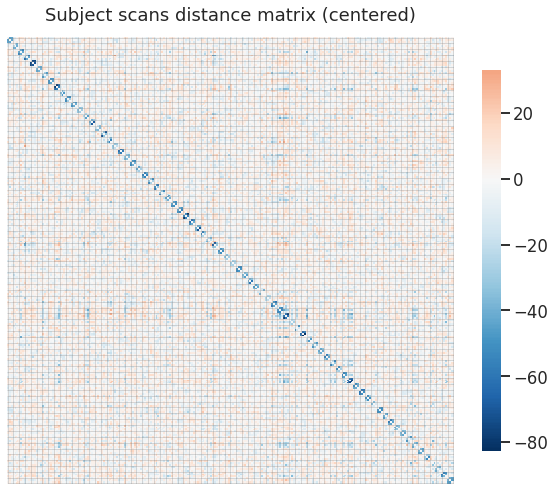

In [72]:
fig = heatmap(
    center_distmat(X_dists),
    title=f"Subject scans distance matrix (centered)",
    transform=None,
    #inner_hier_labels=np.concatenate([[i+1]*3 for i in range(int(X_dists.shape[0]/3))]),#np.sort(np.concatenate(subjs)),
    #hier_label_fontsize=0,
)
ax = _plot_groups(
    fig,
    center_distmat(X_dists),
    np.concatenate([[i+1]*3 for i in range(int(X_dists.shape[0]/3))]),
)
plt.savefig(heatmap_dir / f'doubly_centered_l2_subj_distmat.pdf', bbox_inches='tight')
plt.show()

#### Significant tests

In [74]:
y = np.repeat(labels, [len(g) for g in groups], axis=0)
label_transform = {
    "e": "E.",
    "n": "N.",
    "compassion": "Compasson",
    "restingstate": "Resting",
    "openmonitoring": "Open",
}
y_labels = [f"{label_transform[a]} {label_transform[b]}" if for a, b in y]

In [117]:
name_switch = {
    'Experts All':'E All',
    'Novices All':'N All',
    'Experts Resting':'E Resting.',
    'Experts Open Monitoring':'E Open M.',
    'Experts Compassion':'E Compassion.',
    'Novices Resting':'N Resting',
    'Novices Open Monitoring':'N Open M.',
    'Novices Compassion':'N Compassion',
    'Experts Meditating':'E Med.',
    'Novices Meditating':'N Med.',
    'Resting':'Resting',
    'Compassion':'Compassion',
    'Open Monitoring':'Open Monitoring',
    'Meditating':'Med.',
}

gradients = [
    (0), (1), (2),
    (0,1), (1,2), (2,0),
    (0,1,2)
]

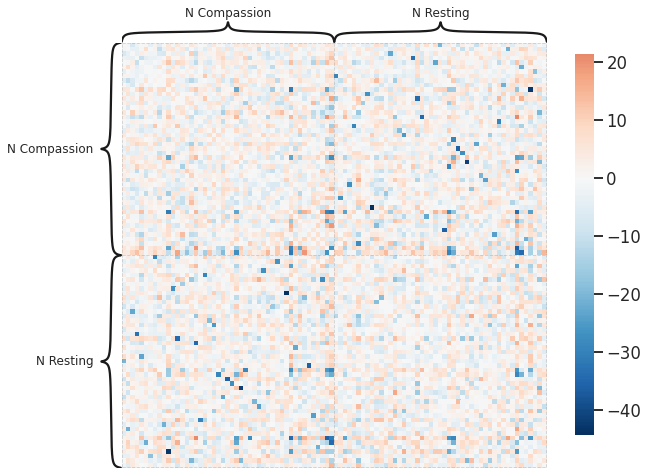

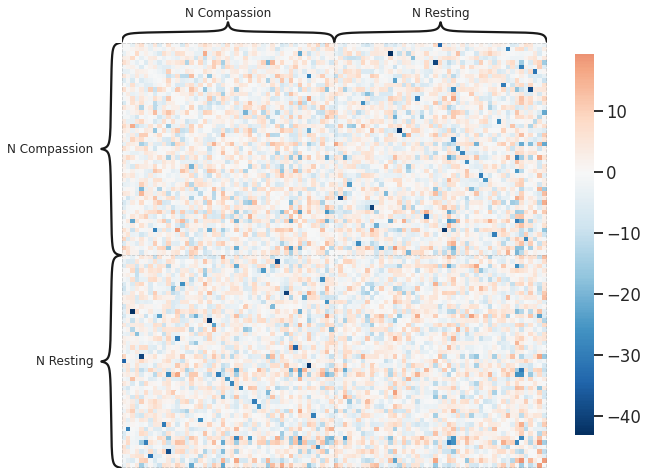

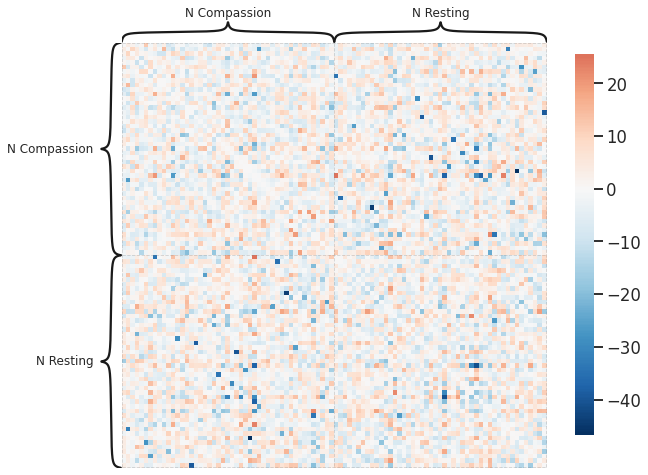

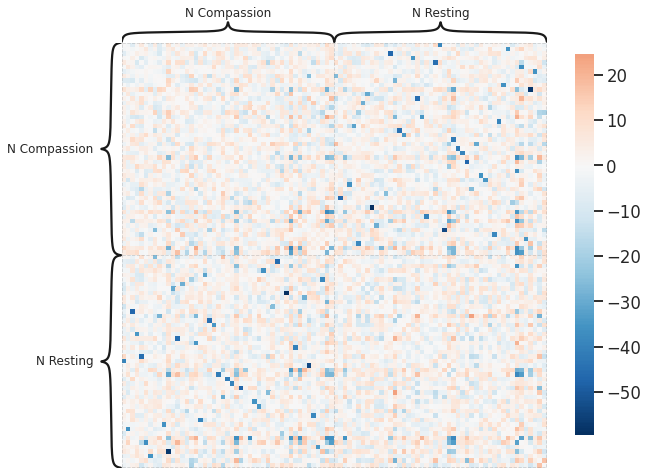

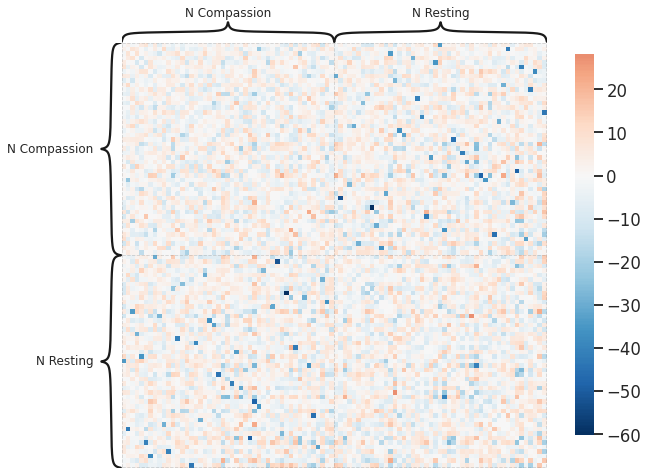

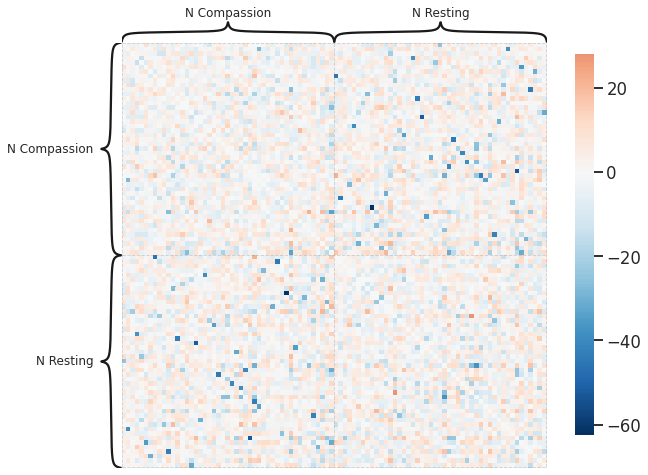

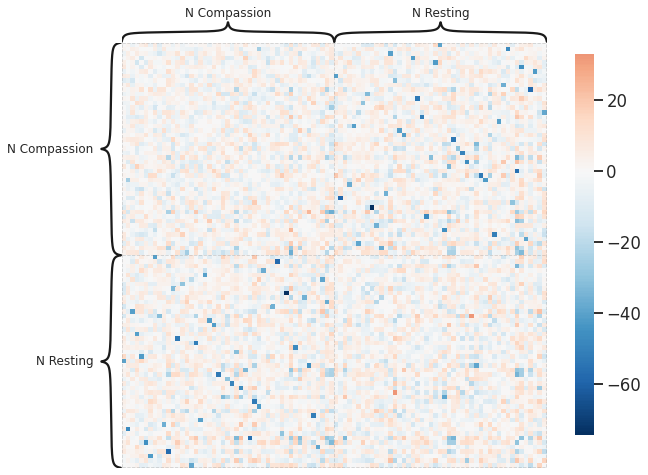

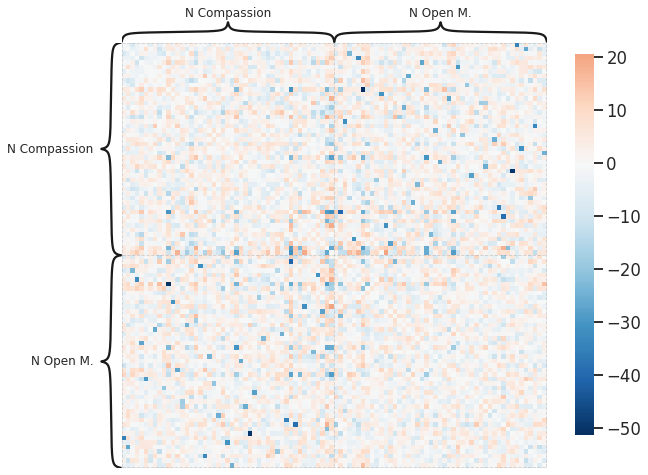

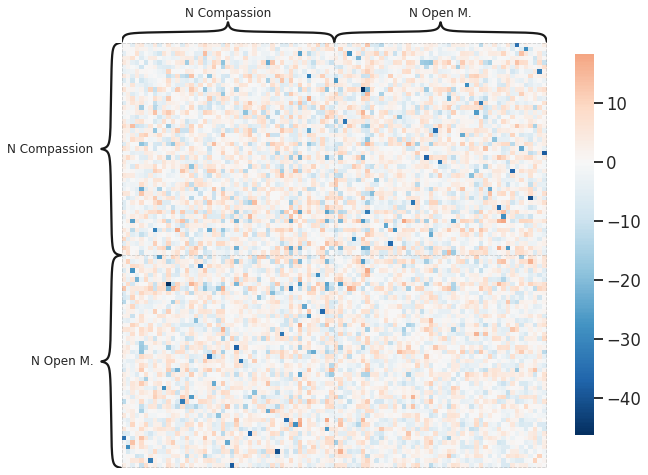

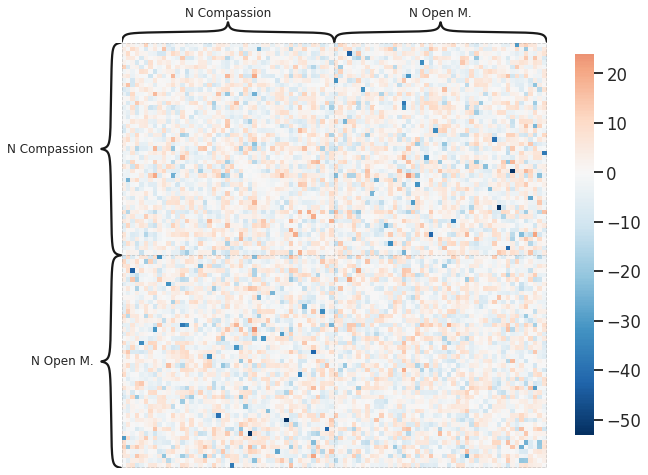

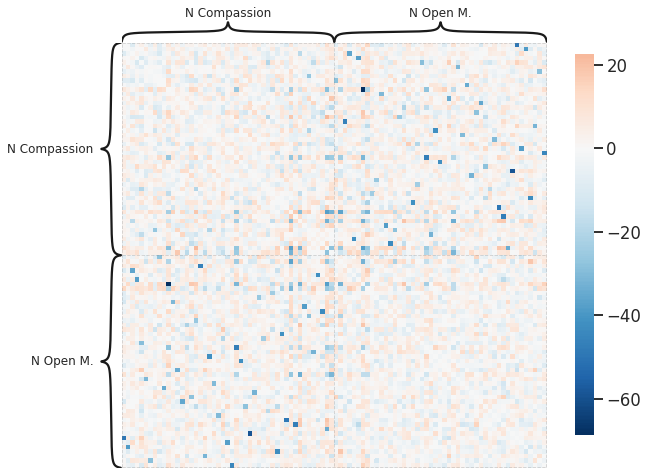

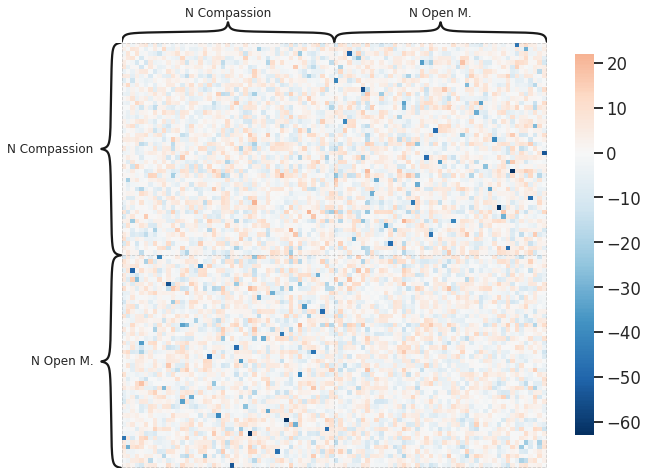

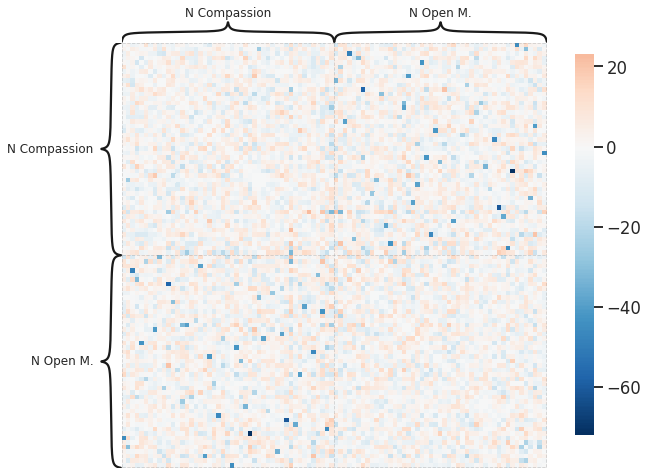

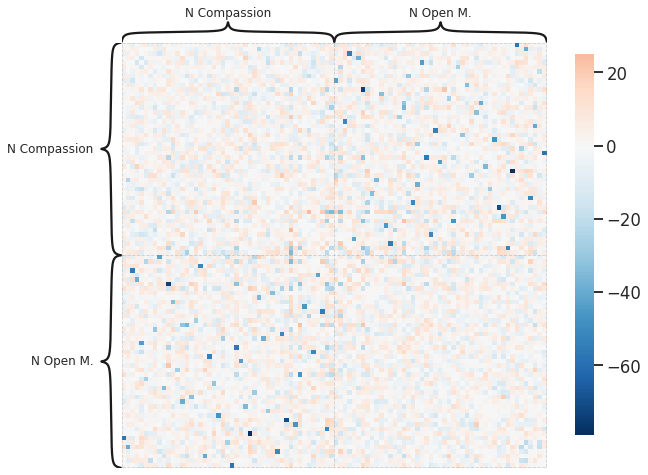

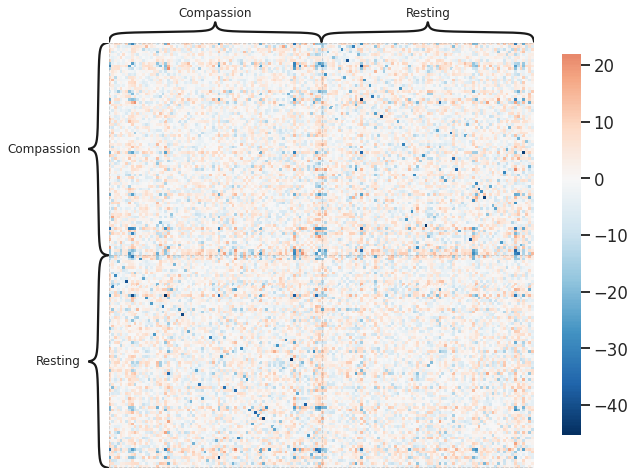

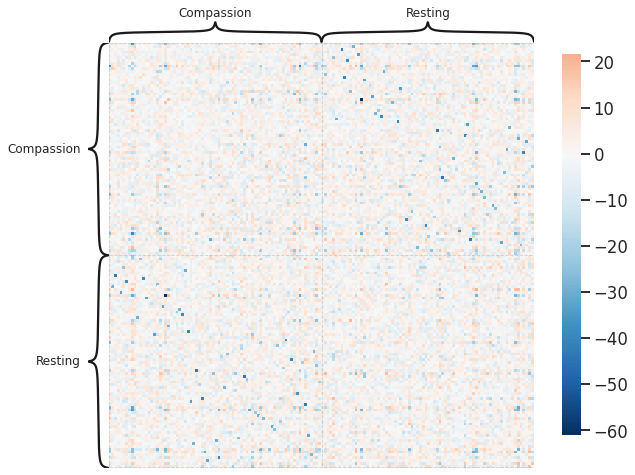

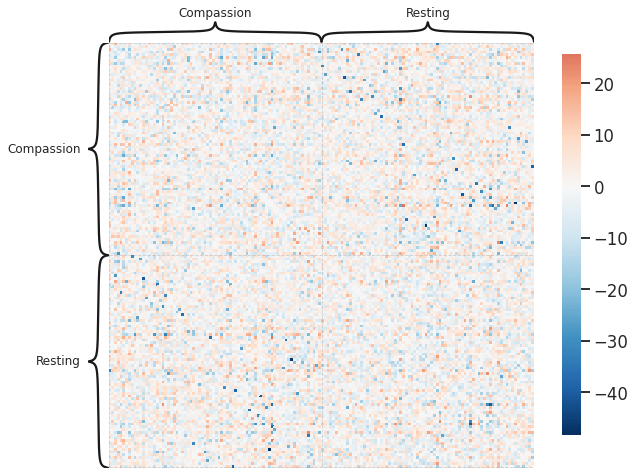

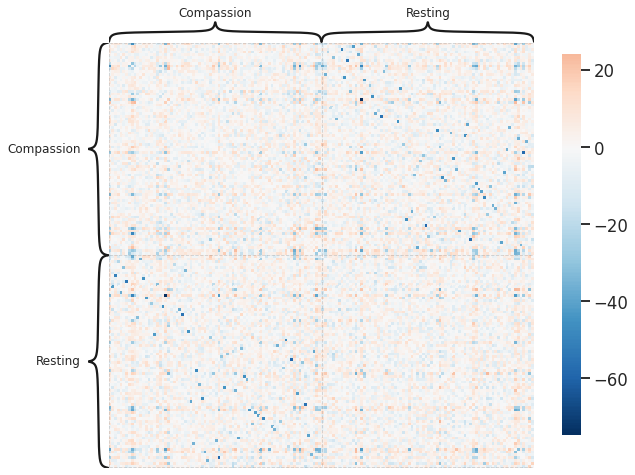

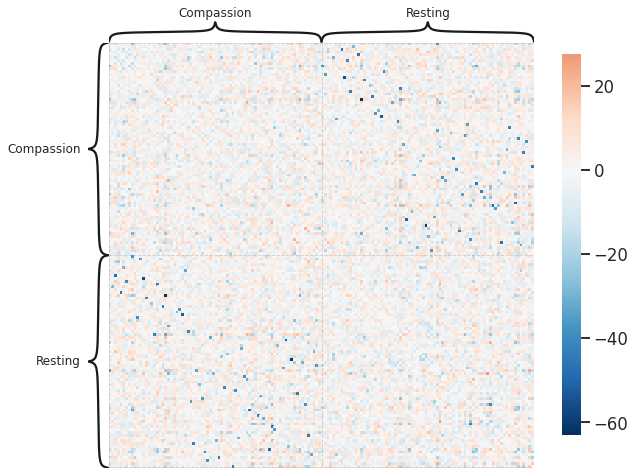

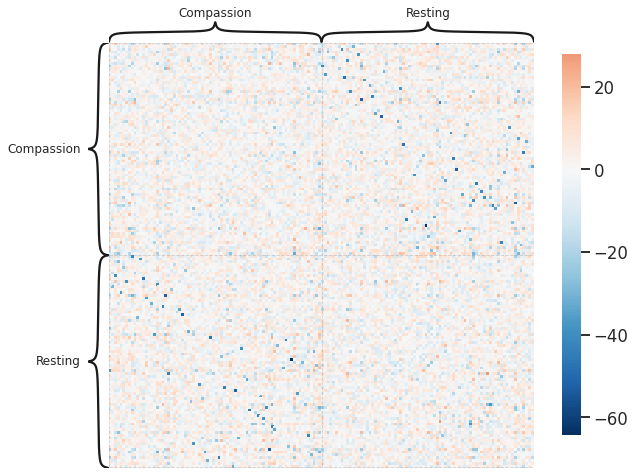

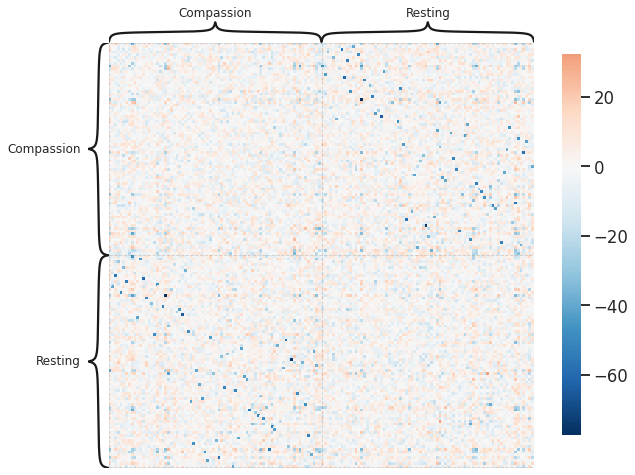

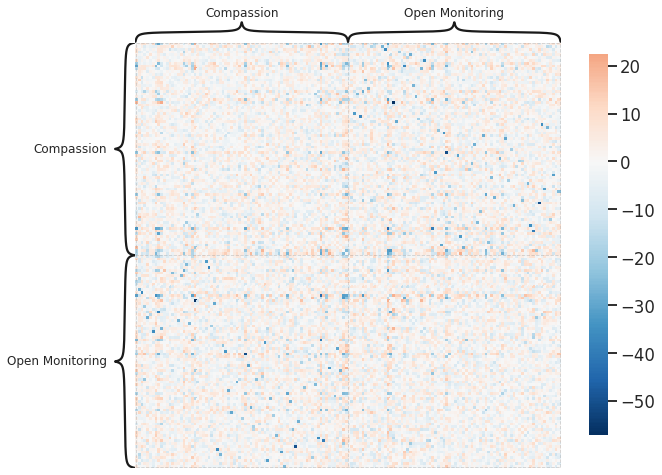

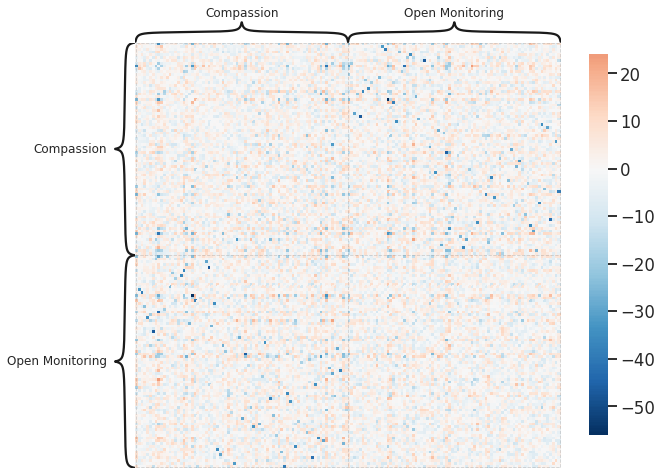

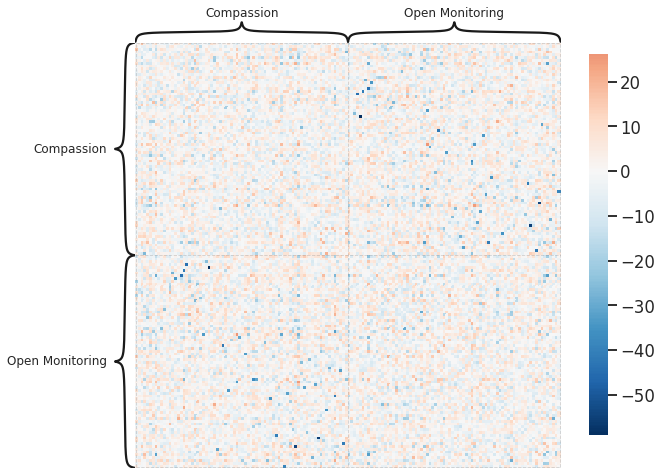

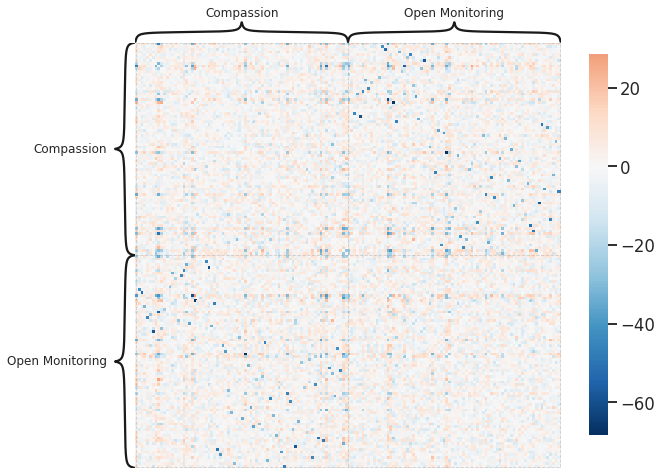

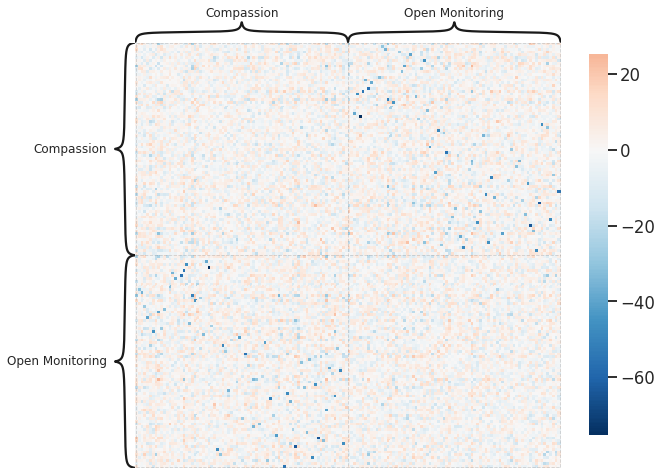

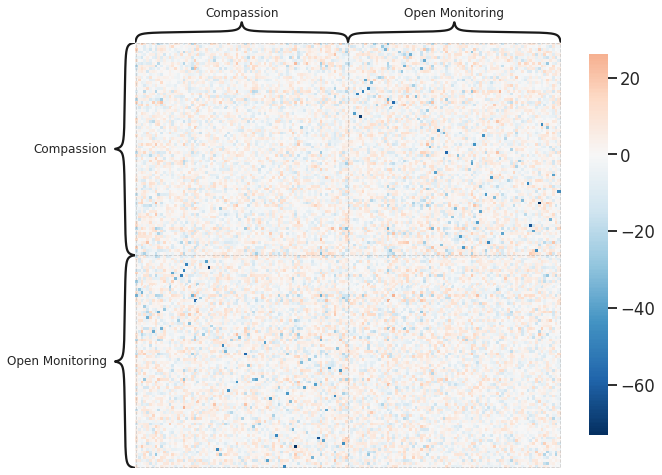

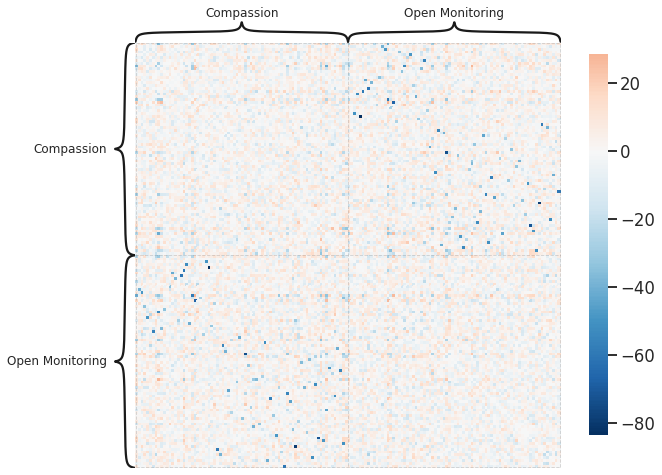

In [119]:
for (g1,g2,permute_structure) in np.asarray(test_list)[SIGNIFICANT_TESTS]:
    name = f'{g1} vs. {g2}'
    results_dict = {}
    
    g1_labels = lookup[g1]
    g2_labels = lookup[g2]

    X1 = np.vstack([np.asarray(groups[i]) for i in g1_labels])
    X2 = np.vstack([np.asarray(groups[i]) for i in g2_labels])
    
    tstats = []
    for grads in gradients:
        X1g = X1[:, :, grads].reshape(X1.shape[0], -1)
        X2g = X2[:, :, grads].reshape(X2.shape[0], -1)
        
        X = np.vstack(np.vstack((X1g, X2g)))
        X = X.reshape(X.shape[0], -1)
        X_dists = pairwise_distances(X, metric="euclidean")
        
        fig = heatmap(
            center_distmat(X_dists),
            #title=f"{name} {grads}",
            transform=None,
            inner_hier_labels = [name_switch[g1]]*X1.shape[0] + [name_switch[g2]]*X2.shape[0],
            #inner_hier_labels = ["\n".join(g1.split(" "))]*X1.shape[0] + ["\n".join(g2.split(" "))]*X2.shape[0],
            hier_label_fontsize=12,
        )

        plt.savefig(heatmap_dir / f'{name}_{grads}_centered_distmat.pdf', bbox_inches='tight')
        plt.show()